# Classificação de Músicas do Spotify

* Criação de classificador que identifica músicas que um usuário poderá gostar.
* Treinar o algoritmo, validar o modelo e fazer tunning dos parâmetros do SVM.
* Informações das Features da Base de dados.
* https://developer.spotify.com/web-api/get-audio-features/

## Scripts e Base de dados

In [105]:
import pandas as pd
import numpy as np

from sklearn import metrics, svm, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline



# Base de dados de músicas do Spotify

In [4]:
dataset = pd.read_csv('data.csv', sep=',')

In [5]:
dataset.head()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


# Análise de Dados

In [6]:
#Checando valores Missing
dataset.isnull().sum()

id                  0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
song_title          0
artist              0
dtype: int64

In [7]:
dataset.describe()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


### Variável explicativa e explicada

In [15]:
classes = dataset['target']
dataset.drop('target', axis=1, inplace=True)
dataset.head(15)

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Parallel Lines,Junior Boys
5,5,0.00479,0.804,251333,0.560,0.000000,8,0.1640,-6.682,1,0.1850,85.023,4.0,0.264,Sneakin’,Drake
6,6,0.01450,0.739,241400,0.472,0.000007,1,0.2070,-11.204,1,0.1560,80.030,4.0,0.308,Childs Play,Drake
7,7,0.02020,0.266,349667,0.348,0.664000,10,0.1600,-11.609,0,0.0371,144.154,4.0,0.393,Gyöngyhajú lány,Omega
8,8,0.04810,0.603,202853,0.944,0.000000,11,0.3420,-3.626,0,0.3470,130.035,4.0,0.398,I've Seen Footage,Death Grips
9,9,0.00208,0.836,226840,0.603,0.000000,7,0.5710,-7.792,1,0.2370,99.994,4.0,0.386,Digital Animal,Honey Claws


### Feature Engineering

In [16]:
def remove_features(lista_features):
    for i in lista_features:
        dataset.drop(i, axis=1, inplace=True)
    return 0

In [17]:
remove_features(['id','song_title'])
dataset.artist.head(10)

0              Future
1    Childish Gambino
2              Future
3         Beach House
4         Junior Boys
5               Drake
6               Drake
7               Omega
8         Death Grips
9         Honey Claws
Name: artist, dtype: object

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  artist            2017 non-null   object 
dtypes: float64(10), int64(3), object(1)
memory usage: 220.7+ KB


<AxesSubplot:>

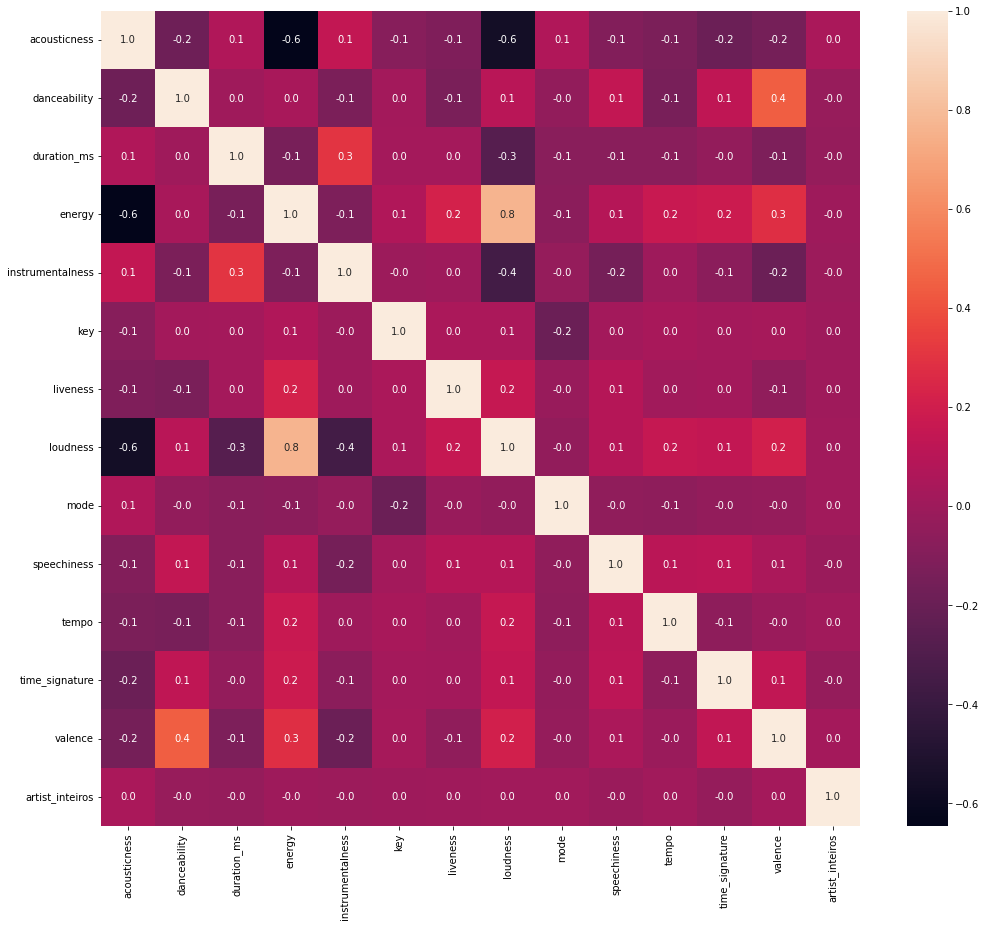

In [54]:
matriz_correlacao =dataset.corr()
plt.figure(figsize = (17, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".1f")

In [91]:
matriz_correlacao_v1 = matriz_correlacao[matriz_correlacao>0.75]
matriz_correlacao_v1

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_inteiros
acousticness,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
danceability,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_ms,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.762177,NaN,NaN,NaN,NaN,NaN,NaN
instrumentalness,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
key,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liveness,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loudness,NaN,NaN,NaN,0.762177,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
speechiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [97]:
dataset = dataset.drop(columns=["energy"]) 

# Label Encoder

In [98]:
enc = LabelEncoder()
dataset['artist_inteiros'] = enc.fit_transform(dataset['artist'])
remove_features(['artist'])

KeyError: 'artist'

# Pipeline

In [78]:
def Acuracia(clf,X,y):
    resultados = cross_val_predict(clf, X, y, cv=10)
    return metrics.accuracy_score(y,resultados)

In [108]:
clf = svm.SVC().fit(dataset,classes)
Acuracia(clf,dataset,classes)


0.5587506197322757

In [77]:
for i in [pip_1,pip_2,pip_3, pip_4, pip_5]:
    print(i.steps)

[('scaler', StandardScaler()), ('clf', SVC())]
[('min_max_scaler', MinMaxScaler()), ('clf', SVC())]
[('scaler', StandardScaler()), ('clf', SVC())]
[('scaler', StandardScaler()), ('clf', SVC(kernel='poly'))]
[('scaler', StandardScaler()), ('clf', SVC(kernel='linear'))]


[('scaler', StandardScaler()), ('clf', SVC())]

In [68]:
# 5 Pipelines
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC())
])

pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', svm.SVC())
])

pip_3 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='rbf'))
])

pip_4 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='poly'))
])

pip_5 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='linear'))
])

In [75]:
for i in [pip_1,pip_2,pip_3, pip_4, pip_5]:

    print(Acuracia(i,dataset,classes))

0.7149231531978185
0.6757560733763014
0.7149231531978185
0.6683192860684184
0.6236985622211205


## Teste de Overfitting

In [93]:
X_train, X_test, y_train, y_test = train_test_split(dataset, classes, test_size=0.2, random_state=301)

In [94]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler2 = StandardScaler().fit(X_test)
X_test = scaler2.transform(X_test)

In [95]:
clf.fit(X_train, y_train)
y_pred  = clf.predict(X_test)
metrics.accuracy_score(y_test,y_pred)


0.7400990099009901

In [96]:
y_pred  = clf.predict(X_train)
metrics.accuracy_score(y_train,y_pred)

0.8140111593304402


# Tunning

In [116]:
lista_C = [0.001, 0.01, 0.1, 1, 10, 100]
lista_gamma = [0.001, 0.01, 0.1, 1, 10, 100]
parametros_grid = dict(clf__C=lista_C, clf__gamma=lista_gamma)
grid = GridSearchCV(pip_3, parametros_grid, cv=10, scoring='accuracy')
grid.fit(dataset,classes)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

# Resultados de Grid

In [131]:
print('Utilizamos o seguinte grid Search:  {}'.format(grid.score))
print('Os melhores parametros foram: {} '.format(grid.best_params_))
print('O melhor parâmetro retornou %f ' %grid.best_score_)

Utilizamos o seguinte grid Search:  <bound method BaseSearchCV.score of GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')>
Os melhores parametros foram: {'clf__C': 100, 'clf__gamma': 0.01} 
O melhor parâmetro retornou 0.702015 
